In [37]:
import logging
import os
import pandas as pd
import re
import time

%load_ext autoreload
%autoreload 2

from pathlib import Path

# Disable logging of the program in the notebook
os.environ["LOGLEVEL"] = "INFO"

logging.basicConfig()
logging.root.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('__main__')
logger.setLevel(os.environ.get("LOGLEVEL", logging.INFO))

pybooklogger = logging.getLogger('pybook')
pybooklogger.setLevel(logging.INFO)

import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.path.abspath("__file__")), '..')))
from setup import *
from tad_help import TadRunner

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
save_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), "results", "corridor")
layout = Layout("../data/corridor/corridor_tracks.json")
scenario_file = "../data/corridor/scenario_2trains.json"

tad_exp = TadRunner(layout, scenario_file, save_dir)
experiments = tad_exp.run("1", "o", "U|1", "V|1", timeout=600)

experiments[0].metadata = {'color': 'Red',   'label': '@SIPP',    'offset': 0, 'linestyle': 3}
experiments[1].metadata = {'color': 'Blue',  'label': 'FlexSIPP', 'offset': 0, 'linestyle': 3}
experiments[2].metadata = {'color': 'Green', 'label': 'rSIPP',    'offset': 0, 'linestyle': 3}

os.makedirs(save_dir, exist_ok=True)
path_data = get_path_data(experiments, tad_exp.agent_df, scenario=scenario_file)
path_df = pd.DataFrame(path_data)
path_df.to_csv(save_dir + "/corridor.csv")

time_data = [exp.get_running_time() | exp.get_label() | {'scenario': scenario_file} for exp in experiments]
time_df = pd.DataFrame(time_data)
time_df.to_csv(save_dir + "/corridor-time.csv")

comp_data = [exp.get_complexity()   | exp.get_label() | {'scenario': scenario_file} for exp in experiments]
comp_df = pd.DataFrame(comp_data)
comp_df.to_csv(save_dir + "/corridor-comp.csv")

INFO:__main__.generation.graph:Creating initial signals
INFO:__main__.generation.graph:  0%|          | 0/20 [00:00<?, ?it/s]
INFO:__main__.generation.graph:Found 1 routes [([Node suA, Node wA], 101, 55.55555555555556)] for signal block from signal Signal u|A on track uA
INFO:__main__.generation.graph:Found 1 routes [([Node s1A], 100, 55.55555555555556)] for signal block from signal Signal w|A on track wA
INFO:__main__.generation.graph:Found 1 routes [([Node suHatA, Node wA], 101, 55.55555555555556)] for signal block from signal Signal uHat|A on track uHatA
INFO:__main__.generation.graph:Found 1 routes [([Node s2A], 100, 55.55555555555556)] for signal block from signal Signal s1|A on track s1A
INFO:__main__.generation.graph:Found 2 routes [([Node wBR, Node suB], 101, 55.55555555555556), ([Node wBR, Node wBL, Node suHatB], 101, 55.55555555555556)] for signal block from signal Signal s1|B on track s1B
INFO:__main__.generation.graph:Found 1 routes [([Node s3A], 100, 55.55555555555556)] fo

Graph with 22 edges and 20 nodes:
dict_values([Node r-u|A, Node r-w|A, Node r-uHat|A, Node r-s1|A, Node r-s1|B, Node r-s2|A, Node r-s2|B, Node r-s3|A, Node r-s3|B, Node r-s4|A, Node r-s4|B, Node r-s5|A, Node r-s5|B, Node r-s6|B, Node r-v|B, Node r-vHat|B, Node r-su|B, Node r-suHat|B, Node r-sv|A, Node r-svHat|A]) r-v|B
Graph with 22 edges and 20 nodes:
dict_values([Node r-u|A, Node r-w|A, Node r-uHat|A, Node r-s1|A, Node r-s1|B, Node r-s2|A, Node r-s2|B, Node r-s3|A, Node r-s3|B, Node r-s4|A, Node r-s4|B, Node r-s5|A, Node r-s5|B, Node r-s6|B, Node r-v|B, Node r-vHat|B, Node r-su|B, Node r-suHat|B, Node r-sv|A, Node r-svHat|A]) r-v|B
Graph with 22 edges and 20 nodes:
dict_values([Node r-u|A, Node r-w|A, Node r-uHat|A, Node r-s1|A, Node r-s1|B, Node r-s2|A, Node r-s2|B, Node r-s3|A, Node r-s3|B, Node r-s4|A, Node r-s4|B, Node r-s5|A, Node r-s5|B, Node r-s6|B, Node r-v|B, Node r-vHat|B, Node r-su|B, Node r-suHat|B, Node r-sv|A, Node r-svHat|A]) r-v|B


INFO:__main__.generation.convert_to_safe_intervals:Safe intervals on node r-sv|A
INFO:__main__.generation.convert_to_safe_intervals:    Interval (0, 20000, 0, 0, 0, 0) with index 32
INFO:__main__.generation.convert_to_safe_intervals:Safe intervals on node r-svHat|A
INFO:__main__.generation.convert_to_safe_intervals:    Interval (0, 1770, 0, 2, 0, 0) with index 33
INFO:__main__.generation.convert_to_safe_intervals:    Interval (1872.7269444444444, 20000, 2, 0, 0, 0) with index 34
INFO:__main__.generation.convert_to_safe_intervals:Edge has interval from r-u|A state 0 (0, 20000, 0, 0, 0, 0) to r-w|A state 1 (0, 2202.7269444444446, 0, 2, 0, 0) with zeta 0, alpha 0, beta 2200.1298015873017, delta 2.5971428571428574, train_before 0 and train_after 0.
INFO:__main__.generation.convert_to_safe_intervals:Edge has interval from r-u|A state 0 (0, 20000, 0, 0, 0, 0) to r-w|A state 2 (2305.4469444444444, 20000, 2, 0, 0, 0) with zeta 0, alpha 2326.166944444444, beta 19997.402857142857, delta 2.597142

Exp @SIPP - atf: <-inf,0.0,1554.55,23.1943>
Exp @SIPP - atf: <-inf,2126.17,19776.8,23.1943>
Exp FlexSIPP - atf: <-inf,0.0,1554.55,23.1943>
Exp FlexSIPP - atf: <-inf,1554.55,1627.27,23.1943>
Exp FlexSIPP - atf: <-inf,1627.27,1629.12,23.1943>
Exp FlexSIPP - atf: <-inf,1629.12,1701.84,23.1943>
Exp FlexSIPP - atf: <-inf,1701.84,1703.69,23.1943>
Exp FlexSIPP - atf: <-inf,1703.69,1776.42,23.1943>
Exp FlexSIPP - atf: <-inf,1776.42,1778.26,23.1943>
Exp FlexSIPP - atf: <-inf,1778.26,1850.99,23.1943>
Exp FlexSIPP - atf: <-inf,1850.99,1852.83,23.1943>
Exp FlexSIPP - atf: <-inf,1852.83,1925.56,23.1943>
Exp FlexSIPP - atf: <-inf,1925.56,1927.4,23.1943>
Exp FlexSIPP - atf: <-inf,1927.4,2000.13,23.1943>
Exp FlexSIPP - atf: <-inf,2000.13,2454.55,23.1943>
Exp rSIPP - atf: <-inf,0.0,1554.55,23.1943>
Exp rSIPP - atf: <-inf,2126.17,19776.8,23.1943>


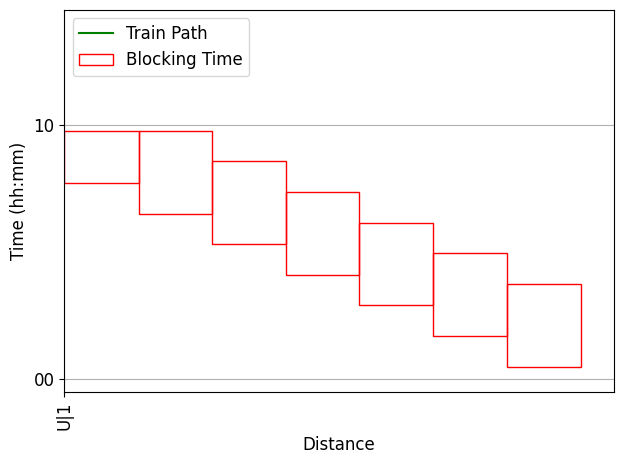

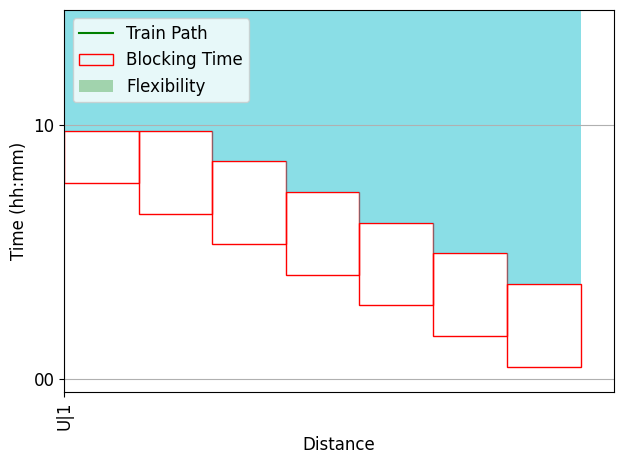

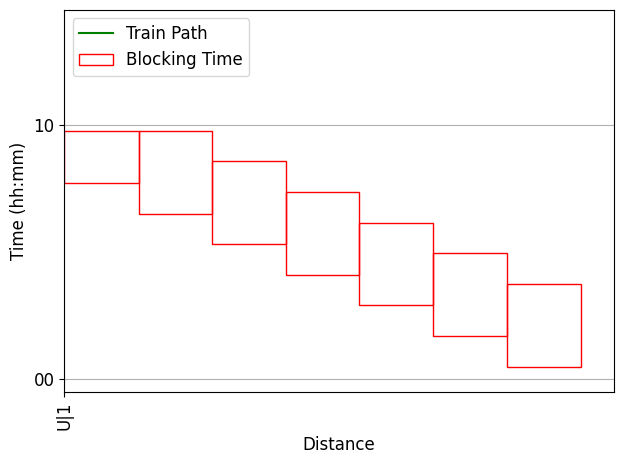

In [39]:
for exp in experiments:
    exp.s.plot(exp.agent.id, exp.block_intervals, exp.buffer_times, exp.recovery_times, True, start="U", end="V", min_y=28.5*60, max_y=(28.5+15)*60, savefig=f"{save_dir}/blocking_staircase_{exp.metadata['label'].replace(' ', '_')}.png")